In [1]:
#Notebook for doing the actual classification

In [2]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, TextDataset, MultimodalDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd

In [3]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = '..\\text_only\\embeddings\\bert_embeddings'
val_bert = '..\\text_only\\embeddings\\bert_embeddings_val'
test_bert = '..\\text_only\\embeddings\\bert_embeddings_test'

train_audio = '.\\data\\MELD\\audio\\wav\\'

val_audio = '.\\data\\MELD\\audio\\wav_dev\\'

In [25]:
train = MultimodalDataset(train_annotations, train_audio, train_bert)
# val = MultimodalDataset(val_annotations, val_audio, val_bert)

train, val = train_test_split(train, test_size=0.2)
batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=False)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=False)
train_features, train_labels = next(iter(train_dataloader))


In [27]:


print(f"audio Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
features = train_features[0]
label = train_labels[0]

features.shape,label

audio Feature batch shape: torch.Size([64, 2379])
Labels batch shape: torch.Size([64])


(torch.Size([2379]), tensor(3))

In [28]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [29]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [35]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            try:
                output_logits = model(X)
            except:
                print(X.shape)
                raise AssertionError
            predictions = torch.argmax(output_logits,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_RnnAtten(input_dim = 2379, hidden_dim=128, output_dim=7, num_layers=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.AdamW(model.parameters(),lr=0.0001/2, weight_decay=1e-3)

Number of trainable params:  1648647


In [15]:
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 120
best_val_f1 = 0


for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc, f1= train_step(X_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _, val_f1 = validate(X_val_tensor,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), 'best-bimodal-model-parameters.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}%")


Epoch 1 --> loss:1.8673, acc:24.50%, val_loss:1.8211, val_acc:45.31%  f1:23.35%, val_f1:28.26%

Epoch 2 --> loss:1.7101, acc:43.47%, val_loss:1.7076, val_acc:50.00%  f1:34.35%, val_f1:33.33%

Epoch 3 --> loss:1.6132, acc:46.72%, val_loss:1.5893, val_acc:43.75%  f1:28.41%, val_f1:26.63%

Epoch 4 --> loss:1.5546, acc:46.97%, val_loss:1.3710, val_acc:59.38%  f1:34.35%, val_f1:44.24%

Epoch 5 --> loss:1.5300, acc:47.09%, val_loss:1.4362, val_acc:51.56%  f1:24.66%, val_f1:35.45%

Epoch 6 --> loss:1.5084, acc:47.08%, val_loss:1.4625, val_acc:42.19%  f1:38.50%, val_f1:25.03%

Epoch 7 --> loss:1.4861, acc:47.22%, val_loss:1.4003, val_acc:54.69%  f1:38.35%, val_f1:41.30%

Epoch 8 --> loss:1.4650, acc:47.72%, val_loss:1.4742, val_acc:51.56%  f1:38.43%, val_f1:38.41%

Epoch 9 --> loss:1.4401, acc:48.55%, val_loss:1.3689, val_acc:60.94%  f1:36.75%, val_f1:55.37%

Epoch 10 --> loss:1.4098, acc:50.47%, val_loss:1.4962, val_acc:43.75%  f1:47.72%, val_f1:31.04%

Epoch 11 --> loss:1.3872, acc:51.91%, 

layers:  3
model hidden dim:  128
batch size:  64
Max f1_val:  75.34122588908981


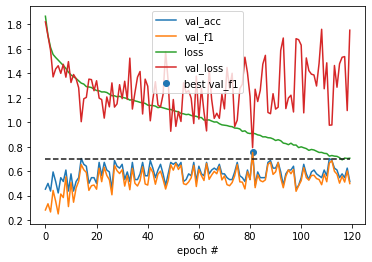

In [16]:

import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100, label='best val_f1')
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()
print("layers: ", model.num_layers)
print("model hidden dim: ", model.hidden_dim)
print("batch size: ", train_dataloader.batch_size)
print("Max f1_val: ", best_val_f1)



In [ ]:

model.load_state_dict(torch.load("best-bimodal-model-parameters.pt"))

In [ ]:
#TODO: fix test loop for multimodaldataset
test = TextDataset(test_annotations, test_bert)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=True, drop_last=False)

device = 'cpu'
model.to(device)

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    output_logits = model(X)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    
print(f1)
